In [573]:
import numpy as np
import csv as c
from os.path import join
import os
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [574]:
path_main = "/Users/jurriaan/ML/kaggle_ObservingDarkWorlds"
path_data = join(path_main, "DarkWorlds")

In [603]:
# load data sky1
skies_train_df_1 = pd.read_csv(join(path_data, "Train_Skies", "Training_Sky1.csv"))
skies_train_df_1

,GalaxyID,x,y,e1,e2
0,Galaxy1,700.87,89.98,-0.050569,-0.301238
1,Galaxy2,570.74,3528.23,-0.248973,0.052048
2,Galaxy3,579.66,1381.65,0.483764,0.060891
3,Galaxy4,1595.64,1226.96,-0.043464,0.207885
4,Galaxy5,444.24,1567.29,-0.102021,-0.207315
...,...,...,...,...,...
343,Galaxy344,3548.83,306.39,0.194440,-0.364194
344,Galaxy345,2957.20,966.09,-0.323762,0.443509
345,Galaxy346,3555.70,722.22,-0.249272,-0.380333
346,Galaxy347,1845.34,3458.47,-0.460082,-0.277290


In [576]:
skies_train_df_1["e"] = skies_train_df_1["e1"] + skies_train_df_1["e2"]
skies_train_df_1["e"].mean(), skies_train_df_1["e"].std()/np.sqrt(348)

(-0.04913945977011495, 0.015574399919514712)

In [577]:
skies_train_df_1

,GalaxyID,x,y,e1,e2,e_t,e_t_abs,r_from_halo,e,e_t2
0,Galaxy1,700.87,89.98,-0.050569,-0.301238,0.160728,0.160728,1094.901184,-0.351807,0.160728
1,Galaxy2,570.74,3528.23,-0.248973,0.052048,-0.205920,0.205920,2468.173298,-0.196925,-0.205920
2,Galaxy3,579.66,1381.65,0.483764,0.060891,-0.223530,0.223530,573.150365,0.544655,-0.223530
3,Galaxy4,1595.64,1226.96,-0.043464,0.207885,-0.048110,0.048110,521.095642,0.164421,-0.048110
4,Galaxy5,444.24,1567.29,-0.102021,-0.207315,-0.160874,0.160874,786.004158,-0.309336,-0.160874
...,...,...,...,...,...,...,...,...,...,...
343,Galaxy344,3548.83,306.39,0.194440,-0.364194,-0.372460,0.372460,2591.295292,-0.169754,-0.372460
344,Galaxy345,2957.20,966.09,-0.323762,0.443509,0.389698,0.389698,1876.287385,0.119747,0.389698
345,Galaxy346,3555.70,722.22,-0.249272,-0.380333,0.119073,0.119073,2499.887422,-0.629605,0.119073
346,Galaxy347,1845.34,3458.47,-0.460082,-0.277290,-0.210383,0.210383,2463.546758,-0.737372,-0.210383


In [604]:
d_skies_train_df_1.plot(x="r_from_halo", y="e",kind="scatter")

NameError: name 'd_skies_train_df_1' is not defined

In [579]:
data_directory = "/Users/jurriaan/ML/kaggle_ObservingDarkWorlds/DarkWorlds/"
df, train_halos = load_data(data_directory)

In [580]:
def load_data(data_directory):
    train_halos = pd.read_csv( os.path.join(data_directory, 'Training_halos.csv') )
    test_halo_counts = pd.read_csv( os.path.join(data_directory, 'Test_haloCounts.csv') )

    train_skies = pd.DataFrame()
    for s in os.listdir( os.path.join(data_directory, 'Train_Skies') ):
        if not s.startswith("."):
            try:
                d = pd.read_csv( os.path.join(data_directory, 'Train_Skies', s) )
                d['SkyId'] = s.split("_")[1].split(".")[0]
                d['ID'] = d['SkyId'].map(lambda x: int( str(x).split('y')[1]) )-1
                d['a'] = 1/(1-np.sqrt(d['e1']**2 + d['e2']**2))
                d['b'] = 1/(1+np.sqrt(d['e1']**2 + d['e2']**2))
                d['theta'] = np.degrees(np.arctan2(d['e2'], d['e1'])*0.5)
                d['e1_norm'] = (d.e1-d.e1.mean()) / d.e1.std()
                d['e2_norm'] = (d.e2-d.e2.mean()) / d.e2.std()
                train_skies = train_skies.append(d)
            except Exception as e:
                print(s)
                print(s,' -> ', e.message)

    test_skies = pd.DataFrame()
    for s in os.listdir( os.path.join(data_directory, 'Test_Skies') ):
        if not s.startswith("."):
            try:
                d = pd.read_csv( os.path.join(data_directory, 'Test_Skies', s) )
                d['SkyId'] = s.split("_")[1].split(".")[0]
                d['ID'] = d['SkyId'].map(lambda x: int( str(x).split('y')[1]) )-1
                d['a'] = 1/(1-np.sqrt(d['e1']**2 + d['e2']**2))
                d['b'] = 1/(1+np.sqrt(d['e1']**2 + d['e2']**2))
                d['theta'] = np.degrees(np.arctan2(d['e2'], d['e1'])*0.5)
                d['e1_norm'] = (d.e1-d.e1.mean()) / d.e1.std()
                d['e2_norm'] = (d.e2-d.e2.mean()) / d.e2.std()
                test_skies = test_skies.append(d)
            except Exception as e:
                print(s,' -> ', e.message)

    df = pd.merge(train_skies, train_halos, on='SkyId')
    #df_test = pd.merge(test_skies, test_halo_counts, on='SkyId')

    return df, train_halos

In [581]:
data_directory = "/Users/jurriaan/ML/kaggle_ObservingDarkWorlds/DarkWorlds/"
df, train_halos = load_data(data_directory)

In [582]:
df.head()

,GalaxyID,x,y,e1,e2,SkyId,ID,a,b,theta,...,e2_norm,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Galaxy1,1178.86,1437.77,-0.123701,-0.221946,Sky4,3,1.340645,0.797391,-59.566495,...,-0.985981,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
1,Galaxy2,584.59,1902.17,-0.120514,0.376603,Sky4,3,1.654029,0.716632,53.872408,...,1.709267,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
2,Galaxy3,3559.55,3354.40,0.359900,-0.261081,Sky4,3,1.800585,0.692221,-17.979063,...,-1.162204,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
3,Galaxy4,1032.82,342.05,0.198778,-0.078965,Sky4,3,1.272084,0.823799,-10.832780,...,-0.342142,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Galaxy5,970.10,3083.41,0.132988,-0.196745,Sky4,3,1.311433,0.808097,-27.971815,...,-0.872501,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0


In [583]:
no_halos = 1
print(df[df.numberHalos == no_halos].x.mean())
print(df[df.numberHalos == no_halos].x.std())
print(df[df.numberHalos == no_halos].y.mean())
print(df[df.numberHalos == no_halos].y.std())

2109.852284738213
1211.2475239751916
2107.2199439432256
1209.0307112088547


In [584]:
no_halos = 1
print(df[df.numberHalos == no_halos].e1.mean())
print(df[df.numberHalos == no_halos].e1.std())
print(df[df.numberHalos == no_halos].e2.mean())
print(df[df.numberHalos == no_halos].e2.std())

0.0010670978256766453
0.22170849885280777
-0.00047651753425691733
0.21947368427807107


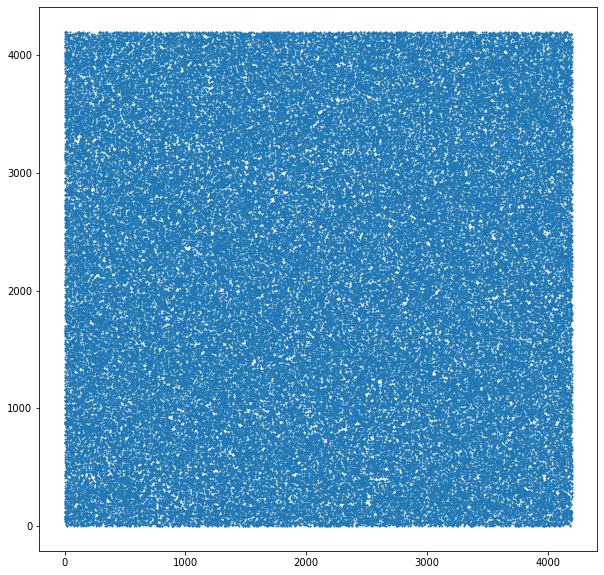

In [585]:
plt.figure(figsize=(10,10))
plt.scatter( df['x'], df['y'], s=1, cmap=plt.cm.gray )
plt.savefig('x_vs_y_distribution.pdf', format='pdf')

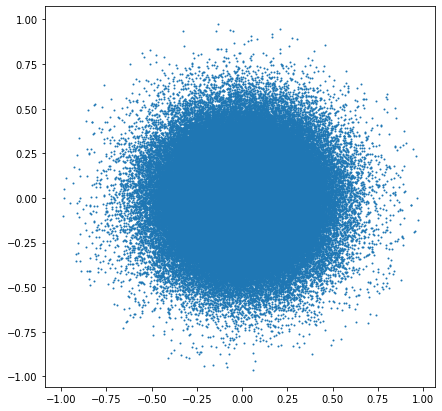

In [586]:
plt.figure(figsize=(7,7))
plt.scatter( df['e1'], df['e2'], s=1, cmap=plt.cm.gray )
plt.savefig('e1_vs_e2_norm_distribution.pdf', format='pdf')

In [587]:
df

,GalaxyID,x,y,e1,e2,SkyId,ID,a,b,theta,...,e2_norm,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Galaxy1,1178.86,1437.77,-0.123701,-0.221946,Sky4,3,1.340645,0.797391,-59.566495,...,-0.985981,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
1,Galaxy2,584.59,1902.17,-0.120514,0.376603,Sky4,3,1.654029,0.716632,53.872408,...,1.709267,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
2,Galaxy3,3559.55,3354.40,0.359900,-0.261081,Sky4,3,1.800585,0.692221,-17.979063,...,-1.162204,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
3,Galaxy4,1032.82,342.05,0.198778,-0.078965,Sky4,3,1.272084,0.823799,-10.832780,...,-0.342142,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Galaxy5,970.10,3083.41,0.132988,-0.196745,Sky4,3,1.311433,0.808097,-27.971815,...,-0.872501,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160837,Galaxy570,861.10,4122.24,-0.246066,0.083360,Sky9,8,1.350991,0.793775,80.642558,...,0.439677,1,2556.11,2645.23,2556.11,2645.23,0.0,0.0,0.0,0.0
160838,Galaxy571,1962.07,2466.81,-0.114714,-0.119102,Sky9,8,1.198124,0.858102,-66.962431,...,-0.551842,1,2556.11,2645.23,2556.11,2645.23,0.0,0.0,0.0,0.0
160839,Galaxy572,446.71,3140.83,0.144135,0.028780,Sky9,8,1.172306,0.871855,5.645983,...,0.172382,1,2556.11,2645.23,2556.11,2645.23,0.0,0.0,0.0,0.0
160840,Galaxy573,201.79,1154.67,0.174669,-0.078262,Sky9,8,1.236706,0.839348,-12.067595,...,-0.351836,1,2556.11,2645.23,2556.11,2645.23,0.0,0.0,0.0,0.0


In [588]:
sorted(df["SkyId"].unique())

['Sky1',
 'Sky10',
 'Sky100',
 'Sky101',
 'Sky102',
 'Sky103',
 'Sky104',
 'Sky105',
 'Sky106',
 'Sky107',
 'Sky108',
 'Sky109',
 'Sky11',
 'Sky110',
 'Sky111',
 'Sky112',
 'Sky113',
 'Sky114',
 'Sky115',
 'Sky116',
 'Sky117',
 'Sky118',
 'Sky119',
 'Sky12',
 'Sky120',
 'Sky121',
 'Sky122',
 'Sky123',
 'Sky124',
 'Sky125',
 'Sky126',
 'Sky127',
 'Sky128',
 'Sky129',
 'Sky13',
 'Sky130',
 'Sky131',
 'Sky132',
 'Sky133',
 'Sky134',
 'Sky135',
 'Sky136',
 'Sky137',
 'Sky138',
 'Sky139',
 'Sky14',
 'Sky140',
 'Sky141',
 'Sky142',
 'Sky143',
 'Sky144',
 'Sky145',
 'Sky146',
 'Sky147',
 'Sky148',
 'Sky149',
 'Sky15',
 'Sky150',
 'Sky151',
 'Sky152',
 'Sky153',
 'Sky154',
 'Sky155',
 'Sky156',
 'Sky157',
 'Sky158',
 'Sky159',
 'Sky16',
 'Sky160',
 'Sky161',
 'Sky162',
 'Sky163',
 'Sky164',
 'Sky165',
 'Sky166',
 'Sky167',
 'Sky168',
 'Sky169',
 'Sky17',
 'Sky170',
 'Sky171',
 'Sky172',
 'Sky173',
 'Sky174',
 'Sky175',
 'Sky176',
 'Sky177',
 'Sky178',
 'Sky179',
 'Sky18',
 'Sky180',
 'Sky181',

In [589]:
df["phi"] = np.arctan2( (df["y"] - df["halo_y1"]), (df["x"] - df["halo_x1"]) )
df["signal"] =  (-( df["e1"]*np.cos(2*df["phi"]) + df["e2"]*np.sin(2*df["phi"]) ))
df["r_halo1"] = ( (df["x"]-df["halo_x1"])**2 + (df["y"]-df["halo_y1"])**2 )**(0.5)

In [590]:
df1 = df[df.numberHalos == 1]

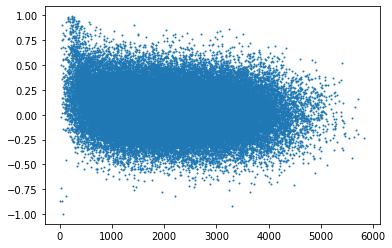

In [591]:
plt.scatter(df1["r_halo1"], df1["signal"], s=1)

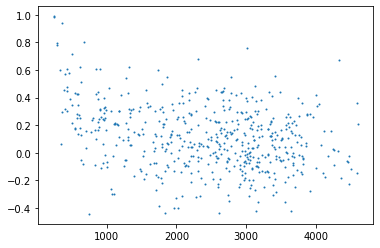

In [592]:
test_sky_ID = 50
df1_sky = df1[df1.ID == test_sky_ID]
plt.scatter(df1_sky["r_halo1"], df1_sky["signal"], s=1)

In [593]:
n_bins=100
df_stats = df1.groupby(pd.cut(df1['r_halo1'], bins=n_bins)).mean().rename(columns={"signal":"mean_signal", "r_halo1":"mean_r_halo_1"})
df_std =  df1.groupby(pd.cut(df1['r_halo1'], bins=n_bins)).std().rename(columns={"signal":"std_signal", "r_halo1":"std_r_halo_1"})
df_size = df1.groupby(pd.cut(df1['r_halo1'], bins=n_bins)).size().to_frame(name="n")

In [594]:
df_stats = pd.concat([df_stats, df_std, df_size], axis=1)
df_stats.head()

,x,y,e1,e2,ID,a,b,theta,e1_norm,e2_norm,...,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3,phi,std_signal,std_r_halo_1,n
r_halo1,,,,,,,,,,,,,,,,,,,,,
"(2.481, 66.553]",2229.683000,1975.663000,-0.085149,-0.136172,53.550000,22.854763,0.640838,-30.411151,-0.372595,-0.646402,...,993.513052,1325.992393,0.0,0.0,0.0,0.0,1.840463,0.606766,15.986856,20
"(66.553, 124.799]",2142.918095,2282.948889,-0.041911,0.025033,45.222222,2.148954,0.747633,4.764494,-0.213268,0.099872,...,1201.642066,1253.957715,0.0,0.0,0.0,0.0,1.747643,0.283899,17.122309,63
"(124.799, 183.046]",2166.626214,2309.049709,0.016619,-0.003068,45.184466,3.209561,0.738220,3.608535,0.080972,0.003292,...,1097.474736,1088.446251,0.0,0.0,0.0,0.0,1.788051,0.263783,16.960676,103
"(183.046, 241.293]",2061.990160,2265.949947,-0.029126,0.022793,48.171123,3.681100,0.721950,4.874862,-0.124105,0.103475,...,1094.328506,1118.203189,0.0,0.0,0.0,0.0,1.851654,0.293482,17.272646,187
"(241.293, 299.54]",2160.970847,2233.101169,-0.011384,-0.018438,51.475806,2.700587,0.734204,-3.034511,-0.064436,-0.078477,...,1040.309887,1093.814831,0.0,0.0,0.0,0.0,1.834248,0.304072,17.555161,248


In [595]:
df_stats["std_mean_signal"] = df_stats["std_signal"] /  np.sqrt(df_stats["n"])

In [596]:
df_stats[["mean_signal", "std_mean_signal", "mean_r_halo_1"]]

,mean_signal,std_mean_signal,mean_r_halo_1
r_halo1,,,
"(2.481, 66.553]",0.191991,0.135677,45.449430
"(66.553, 124.799]",0.231268,0.035768,99.861483
"(124.799, 183.046]",0.279842,0.025991,156.912297
"(183.046, 241.293]",0.316122,0.021462,214.649624
"(241.293, 299.54]",0.292984,0.019309,270.973563
...,...,...,...
"(5541.76, 5600.007]",-0.334948,0.096212,5569.274527
"(5600.007, 5658.254]",-0.062132,0.088089,5630.000124
"(5658.254, 5716.501]",-0.062378,0.110638,5695.279180


In [597]:
df_stats.columns

Index(['x', 'y', 'e1', 'e2', 'ID', 'a', 'b', 'theta', 'e1_norm', 'e2_norm',
       'numberHalos', 'x_ref', 'y_ref', 'halo_x1', 'halo_y1', 'halo_x2',
       'halo_y2', 'halo_x3', 'halo_y3', 'phi', 'mean_signal', 'mean_r_halo_1',
       'x', 'y', 'e1', 'e2', 'ID', 'a', 'b', 'theta', 'e1_norm', 'e2_norm',
       'numberHalos', 'x_ref', 'y_ref', 'halo_x1', 'halo_y1', 'halo_x2',
       'halo_y2', 'halo_x3', 'halo_y3', 'phi', 'std_signal', 'std_r_halo_1',
       'n', 'std_mean_signal'],
      dtype='object')

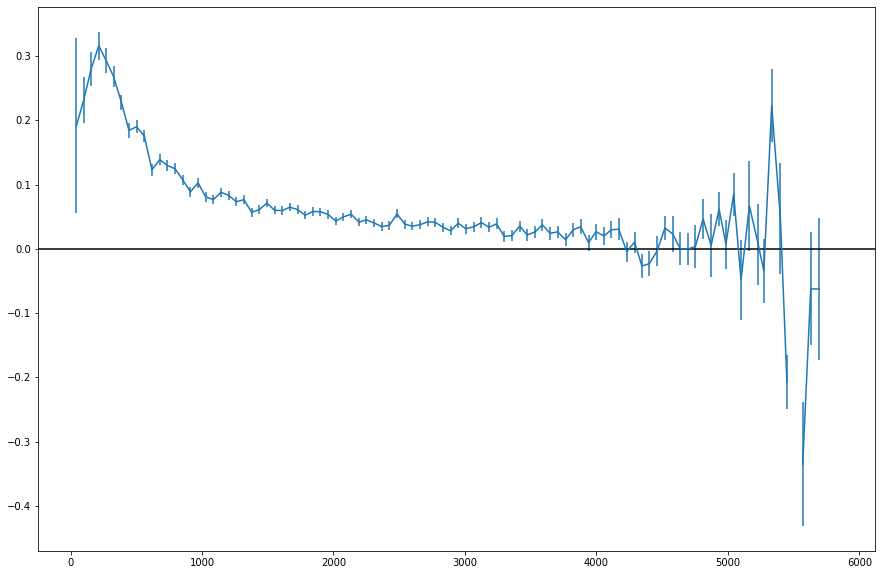

In [598]:
fig, ax = plt.subplots(figsize=(15,10))
xx = df_stats["mean_r_halo_1"].values
yy = df_stats["mean_signal"].values
yerr = df_stats["std_mean_signal"].values
ax.errorbar(xx, yy, yerr=yerr)
plt.axhline(y=0, c="k")

[ 93.46199202 331.02936382]
[9.23858181e+01 2.50000000e+02 7.21060373e-04 1.62724409e-01]


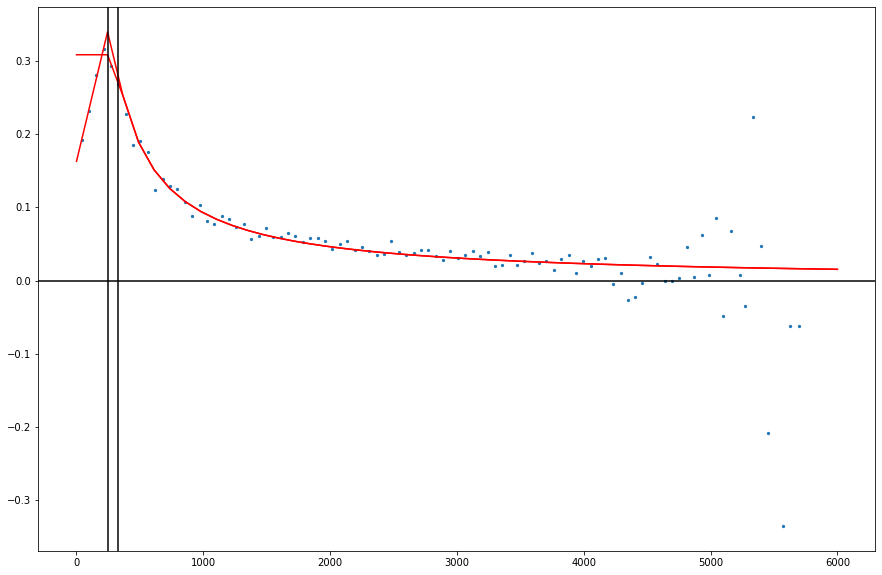

In [599]:
def f1(x, m, x_m):
    """constant signal until x_m, >x_m a 1/r signal"""
    return m / [max(i, x_m) for i in x] 

def f2(x, m1, x_m, m2, b):
    output_x = np.zeros(x.shape)
    for j, i in enumerate(x): 
        if i <= x_m:
            output_x[j] = m2 * i + b
        elif i > x_m:
            output_x[j] = m1 / i
    return output_x

m_fit1, _ = scipy.optimize.curve_fit(f1, 
                                    df_stats.dropna()["mean_r_halo_1"], 
                                    df_stats.dropna()["mean_signal"],
                                    sigma = df_stats.dropna()["std_mean_signal"],
                                    bounds=([1, 200], [10000, 300]))

m_fit2, _ = scipy.optimize.curve_fit(f2, 
                                    df_stats.dropna()["mean_r_halo_1"], 
                                    df_stats.dropna()["mean_signal"],
                                    sigma = df_stats.dropna()["std_mean_signal"],
                                    bounds=([1, 200, 0, 0], [10000, 300, 100, 100]))

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_stats.dropna()["mean_r_halo_1"], df_stats.dropna()["mean_signal"], s=5)
xdata_linspace = np.linspace(0, 6000, 50)

ax.plot(xdata_linspace, f1(xdata_linspace, *m_fit1), c='r')
ax.plot(xdata_linspace, f2(xdata_linspace, *m_fit2), c='r')

ax.axvline(x=m_fit[1], c='k')
ax.axvline(x=m_fit2[1], c='k')

ax.axhline(y=0, c='k')
print(m_fit)
print(m_fit2)

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jurriaan/.conda/envs/pystan/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

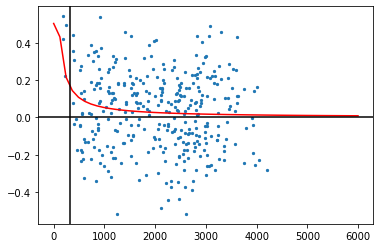

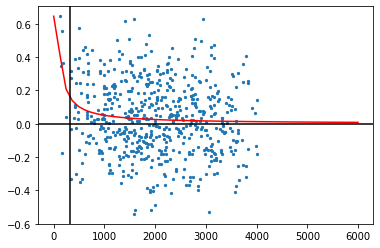

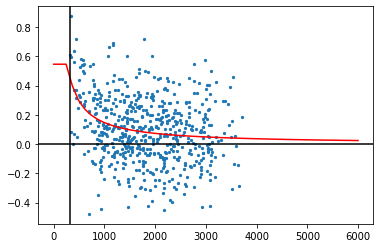

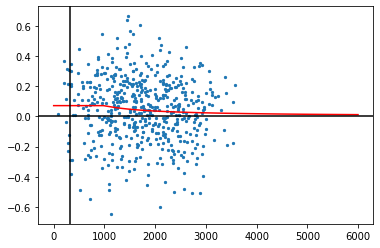

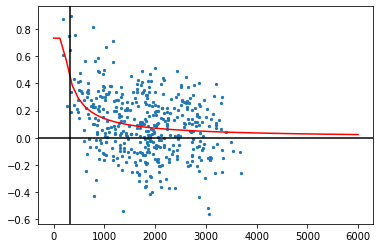

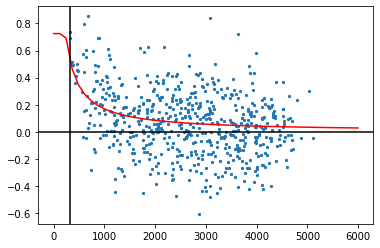

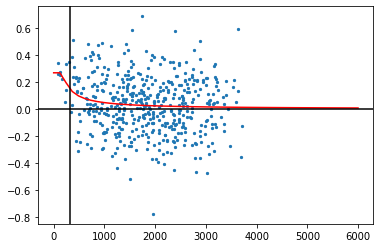

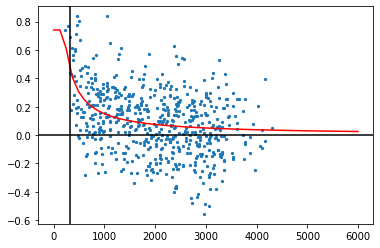

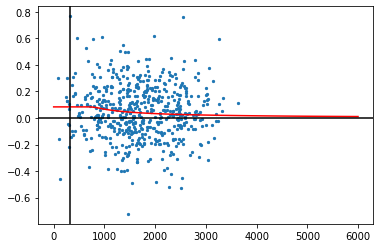

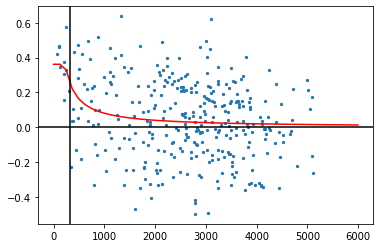

In [600]:
list_m_fit1 = []
for i, sky_ID in enumerate(sorted(df1.ID.unique())):
    df1_sky = df1[df1.ID == sky_ID]
    
    m_fit1, _ = scipy.optimize.curve_fit(f1, 
                                        df1_sky["r_halo1"],
                                        df1_sky["signal"],
                                        bounds=([1, 10], [10000, 1000]))
    df1.loc[df1.ID == sky_ID, "mass"] = m_fit1[0]
    df1.loc[df1.ID == sky_ID, "mass2"] = m_fit2[0]

    if i < 10:
        fig, ax = plt.subplots()
        ax.scatter(df1_sky["r_halo1"],  df1_sky["signal"], s=5)
        xdata_linspace = np.linspace(0, 6000, 50)
        ax.plot(xdata_linspace, f1(xdata_linspace, *m_fit1), c='r')
        ax.axvline(x=m_fit[1], c='k')
        ax.axhline(y=0, c='k')



<AxesSubplot:>

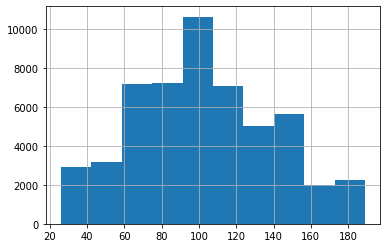

In [601]:
df1["mass"].hist()

<AxesSubplot:>

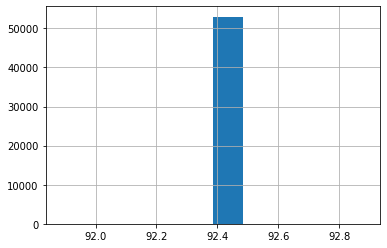

In [602]:
df1["mass2"].hist()

## old

In [ ]:
halos_train_df = pd.read_csv(join(path_data, "Training_halos.csv"))
halos_train_df

In [ ]:
halos_train_df.loc[299, ["halo_x1", "halo_y1", "halo_x2", "halo_y2", "halo_x3", "halo_y3"]]

In [ ]:
def plot_r_ellips_abs(skies_train_df, x0, y0):
    mass = 100
    x = skies_train_df["x"].values
    y = skies_train_df["y"].values
    
    e1 = skies_train_df["e1"].values
    e2 = skies_train_df["e2"].values
    
    r_from_halo = np.sqrt((x-x0)**2+(y-y0)**2)
    angle_wrt_centre = np.arctan((y-y0)/(x-x0))

    skies_train_df["r_from_halo"] = r_from_halo
    
    #force = mass / r_from_halo
    force = 1
    e1_force = -1.*force*np.cos(2.*angle_wrt_centre)
    e2_force = -1.*force*np.sin(2.*angle_wrt_centre)

    skies_train_df["e_t"] = e1_force + e2_force
    skies_train_df["e_t_abs"] = np.abs(skies_train_df["e_t"])
    
    #skies_train_df.plot(x="r_from_halo", y="e_t_abs", kind="scatter", s=5)
    
    xdata = skies_train_df["r_from_halo"].values
    ydata = skies_train_df["e_t_abs"].values

    def f(x, m, x_m):
        return m / [max(i, x_m) for i in x] 

    m_fit, _ = scipy.optimize.curve_fit(f, xdata, ydata, bounds=([1, 10], [10000, 100]))

    fig, ax = plt.subplots()
    ax.scatter(xdata, ydata, s=5)
    xdata_linspace = np.linspace(0, 6000, 50)
    ax.plot(xdata_linspace, f(xdata_linspace, *m_fit), c='r')
    print(m_fit)


    return skies_train_df

In [ ]:
df["e_t"].mean(), df["e_t"].std()

In [ ]:
n = 1
df = plot_r_ellips_abs(d_skies_train_df[n], 
                  halos_train_df.loc[n-1, "halo_x1"].squeeze(), 
                  halos_train_df.loc[n-1, "halo_y1"].squeeze());

In [ ]:
xdata = df["r_from_halo"].values
ydata = df["e_t_abs"].values

def f(x, m, x_m):
    return m / [max(i, x_m) for i in x] 

m_fit, _ = scipy.optimize.curve_fit(f, xdata, ydata, bounds=([1, 10], [10000, 100]))

fig, ax = plt.subplots()
ax.scatter(xdata, ydata, s=5)
xdata_linspace = np.linspace(0, 4200, 50)
ax.plot(xdata_linspace, f(xdata_linspace, *m_fit), c='r')
print(m_fit)

In [ ]:
x0 = 1086.80
y0 = 1114.61

x = skies_train_df_1["x"].values
y = skies_train_df_1["y"].values
e1 = skies_train_df_1["e1"].values
e2 = skies_train_df_1["e2"].values
    
r_from_halo = np.sqrt((x-x0)**2+(y-y0)**2)
skies_train_df_1["r_from_halo"] = r_from_halo

angle_wrt_centre = np.arctan((y-y0)/ (x-x0))
angle_wrt_centre2 = np.arctan2((y-y0), (x-x0))

#force = mass / r_from_halo
e1_force = -e1*np.cos(2.*angle_wrt_centre)
e2_force = -e2*np.sin(2.*angle_wrt_centre)

e1_force2 = -e1*np.cos(2.*angle_wrt_centre2)
e2_force2 = -e2*np.sin(2.*angle_wrt_centre2)


skies_train_df_1["e_t"] = e1_force + e2_force
skies_train_df_1["e_t2"] = e1_force2 + e2_force2
skies_train_df_1["e"] = e1 + e2
skies_train_df_1["e_t_abs"] = np.abs(skies_train_df_1["e_t"])

skies_train_df_1.plot(x="r_from_halo", y="e_t", kind="scatter", s=5)
skies_train_df_1.plot(x="r_from_halo", y="e_t2", kind="scatter", s=5)

In [ ]:
r_from_halo = np.sqrt((x-x0)**2+(y-y0)**2)
plt.hist(r_from_halo, bins=100);

In [ ]:
fig, ax = plt.subplots()
#skies_train_df_1.plot(x="r_from_halo", y="e_t", ax=ax, kind="scatter", c="b")
skies_train_df_1.plot(x="r_from_halo", y="e_t_abs", ax=ax, kind="scatter", s=5)

In [ ]:
# load data sky1
skies_train_df_300 = pd.read_csv(join(path_data, "Train_Skies", "Train_Skies", "Training_Sky300.csv"))
skies_train_df_300

In [ ]:
plot_r_ellips_abs(skies_train_df_120, x0, y0)

In [ ]:
len(list_r)

In [ ]:
halos_train_df

In [ ]:
d_skies_train_df.keys()

In [ ]:
d_skies_train_df[0]

In [ ]:
np.array([1,2,3])**0

In [ ]:
list_r = []
list_et = []


for i in d_skies_train_df:
    skies_train_df = d_skies_train_df[i]
    
    halo_x1 = halos_train_df.loc[i, "halo_x1"].squeeze()
    halo_y1 = halos_train_df.loc[i, "halo_y1"].squeeze()
    
    x = skies_train_df["x"].values
    y = skies_train_df["y"].values
    e1 = skies_train_df["e1"].values
    e2 = skies_train_df["e2"].values

    r_from_halo = np.sqrt((x-halo_x1)**2+(y-halo_y1)**2)
    angle_wrt_centre = np.arctan((y-halo_y1)/(x-halo_x1))
    e1_force = e1*np.cos(2.*angle_wrt_centre)
    e2_force = e2*np.sin(2.*angle_wrt_centre)
    et = -1*(e1_force + e2_force)
    
    list_r.append(r_from_halo)
    list_et.append(et)
    

    if i > 10: 
        break

list_r_fl = [r for l in list_r for r in l]
list_et_fl = [r for l in list_et for r in l]

In [ ]:
len(list_r_fl), len(list_et_fl)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(list_r_fl, list_et_fl, s=5)

In [ ]:
list_r_fl_round = [round(x) for x in list_r_fl]

In [ ]:
df_skies = pd.Series(list_r_fl).to_frame(name="r")
df_skies["et"] = pd.Series(list_et_fl)

In [ ]:
df_skies.head()

In [ ]:
df_skies = df_skies.sort_values("r")
df_skies.head()

In [ ]:
n_bins=50
df_stats = df_skies.groupby(pd.cut(df_skies['r'], bins=n_bins)).mean().rename(columns={"r":"mu_r","et":"mu_et"})
df_std =  df_skies.groupby(pd.cut(df_skies['r'], bins=n_bins)).std().rename(columns={"r":"std_r","et":"std_et"})
df_size = df_skies.groupby(pd.cut(df_skies['r'], bins=n_bins)).size().to_frame(name="n")

In [ ]:
df_stats = pd.concat([df_stats, df_std, df_size], axis=1)
df_stats.head()

In [ ]:
df_stats["std_mu_et"] = df_stats["std_et"] /  np.sqrt(df_stats["n"])

In [ ]:
df_stats

In [ ]:
df_stats["mu_et"].hist(bins=50)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
xx = df_stats["mu_r"].values
yy = df_stats["mu_et"].values
yerr = df_stats["std_mu_et"].values
ax.errorbar(xx, yy, yerr=yerr, label='uplims=True, lolims=True')
plt.axhline(y=0, c="k")

# pystan

In [606]:
len(df1_sky)

391

In [607]:
# data
test_sky_ID = 1
df1_sky = df1[df1.ID == test_sky_ID]

x_1 = list(df1_sky["x"].values)
y_1 = list(df1_sky["y"].values)
e1_1 = list(df1_sky["e1"].values)
e2_1 = list(df1_sky["e2"].values)
sigma2 = 0.05

In [617]:
model_string = """
data {
    int<lower=0> N; 
    vector<lower=-1, upper=1>[N] e1; 
    vector<lower=-1, upper=1>[N]  e2; 
    vector<lower=0, upper=4200>[N]  x; 
    vector<lower=0, upper=4200>[N]  y; 
    real <lower=0.001> sigma2;
}
parameters {
    real<lower=0, upper=4200>  x0;
    real<lower=0, upper=4200>  y0;
    real<lower=0> mass;
}
transformed parameters {   
    vector<lower=0, upper=4200>[N] r_from_halo;
    vector[N] angle_wrt_centre;
    vector[N] force;
    vector[N] signal_1;
    vector[N] signal_2;
    vector[N] signal;
    vector[N] e_t;
    //real<lower=0> mass;

    //mass = 200 * mass0;
    r_from_halo = sqrt((x-x0) .* (x-x0)+(y-y0) .* (y-y0));
    angle_wrt_centre = atan((y-y0) ./ (x-x0));
    force = mass ./ (r_from_halo  + 1);
    signal_1 = -1. * force .* cos(2. * angle_wrt_centre);
    signal_2 = -1. * force .* sin(2. * angle_wrt_centre);
    signal = signal_1 + signal_2;
    e_t = e1 + e2;
}
model {
    mass ~ normal(100, 15); 

    e_t ~ normal(signal, sigma2);
    
}
"""

dict_data = {'N': len(df1_sky),
                "x":x_1,
                "y":y_1,
               'e1': e1_1,
               'e2': e2_1,
               'sigma2': sigma2}


stan_samples = pystan.stan(model_code=model_string, data=dict_data, control={"adapt_delta":0.99})

ValueError: Failed to parse Stan model 'anon_model_f8d5e46f8dd64b137ebcd4e6036fba6b'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
 error in 'unknown file name' at line 17, column 4
  -------------------------------------------------
    15:     vector[N] signal;
    16:     
    17:     signal = signal_1 + signal_2;
           ^
    18:     e_t = e1 + e2;
  -------------------------------------------------

PARSER EXPECTED: <one of the following:
  a variable declaration, beginning with type,
      (int, real, vector, row_vector, matrix, unit_vector,
       simplex, ordered, positive_ordered,
       corr_matrix, cov_matrix,
       cholesky_corr, cholesky_cov
  or '}' to close variable declarations>


Inference for Stan model: anon_model_60019fe3cd4f2c4d06626588442000f2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean      sd     2.5%      25%      50%      75%    97.5%  n_eff   Rhat
x0                      2132.0  697.85  987.22    578.4   1331.1   2290.8   2914.3   3351.6      2  93.72
y0                      1616.1  243.26  344.18   1077.6   1296.4   1727.1   1914.3   1972.7      2  45.36
mass                      12.4    5.53    8.06     2.63     6.86     9.37    18.21    28.71      2   3.97
r_from_halo[1]          1196.8  349.06  493.82   481.18   793.31   1203.8   1581.0   1892.8      2  68.14
r_from_halo[2]          1490.6  374.08  529.28    866.7   1126.0   1375.2   1904.5   2352.9      2  46.75
r_from_halo[3]          1586.9  697.87  987.23    20.92   774.49   1774.5   2396.0   2764.4      2  96.75
r_from_halo[4]          2196.0  682.34  965.27   1085.1   1390.8   19

LinAlgError: singular matrix

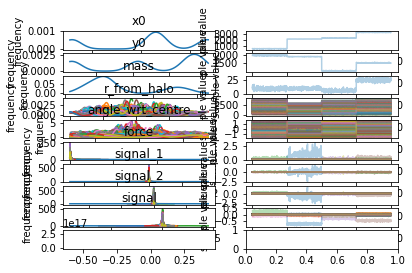

In [609]:
print(stan_samples)
print(stan_samples.plot())

In [611]:
sm = pystan.StanModel(model_code=model_string)
fit = sm.sampling(data=dict_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60019fe3cd4f2c4d06626588442000f2 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [612]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_60019fe3cd4f2c4d06626588442000f2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x0              2021.6   594.3  840.9 1131.2 1358.3 1777.5 2723.5 3403.1      2 179.32
y0              2080.8  238.18 337.09 1569.2 1757.4 2150.4 2406.7 2445.7      2  52.86
mass             16.32    3.76   5.61   8.35  11.15  15.77  21.49  25.36      2   3.17
r_from_halo[1]  983.61  202.61 286.72 620.96  697.6 1010.2 1270.6 1314.1      2  62.03
r_from_halo[2]  1536.8  353.98  500.9 1186.6 1230.3 1266.2 1913.4 2408.3      2  81.37
r_from_halo[3]  1484.0  557.35 788.63 731.95 896.12 1201.1 2122.5 2811.6      2 163.66
r_from_halo[4]  2484.8  616.27  872.0 1072.0 1732.1 2719.8 3208.3 3424.9      2 165.61
r_from_halo[5]  2331.7  202.72 286.87 1933.5 2100.5 2321.3 2565.2 2746.4     

In [ ]:
## return an array of three dimensions: iterations, chains, parameters
la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']
mu